# Init

In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
from evaluation.eval_PartNet import get_mesh_and_gt_tree, get_images, get_shapes

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-07 14:32:14.913758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:32:17.187662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-07 14:32:17.187908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
utils.set_printoptions(linewidth=120)

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes


In [5]:
# example = data_root.joinpath('12012')
example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
cache_dir = cache_root.joinpath(get_hash_name(example.joinpath('objs')))
cache_dir.mkdir(exist_ok=True)
print('Cache Dir:', cache_dir)
# with example.joinpath('meta.json').open('r') as f:
#     meta = json.load(f)
# print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))

Example dir /home/wan/data/PartNet/data_v0/22835
Cache Dir: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28


In [6]:
if cache_dir.joinpath(example.stem + '.mesh_cache').exists() and cache_dir.joinpath('gt.tree3dv2').exists():
    mesh = torch.load(cache_dir.joinpath(example.stem + '.mesh_cache'), map_location=device)
    gt = Tree3Dv2(mesh, device=device)
    gt.load(cache_dir.joinpath('gt.tree3dv2'))
else:
    mesh, gt = get_mesh_and_gt_tree(example, cache_dir)
print(mesh, gt)
gt.print_tree()

[Tree3D] load results from: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28/gt.tree3dv2
Mesh(vertices=75979, faces=30568) <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7f381e67de80>


0: Tree Root
├── 1
└── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    ├── 9
    ├── 10
    ├── 11
    │   ├── 13
    │   └── 14
    └── 12
        ├── 15
        └── 16

F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


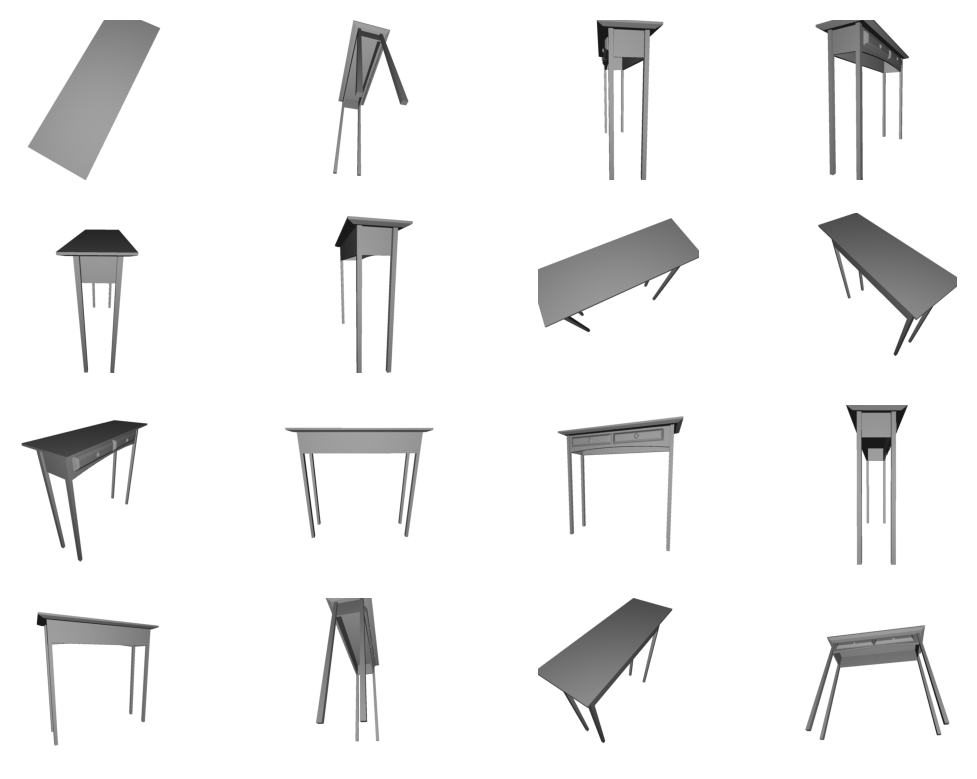

In [7]:
num_views = 100
images, tri_ids, Tw2vs = get_images(mesh.to(device), image_size=1024, num_views=num_views, seed=42)
images, tri_ids, Tw2vs = images.cpu(), tri_ids.cpu(), Tw2vs.cpu()
print(utils.show_shape(images, tri_ids, Tw2vs))
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

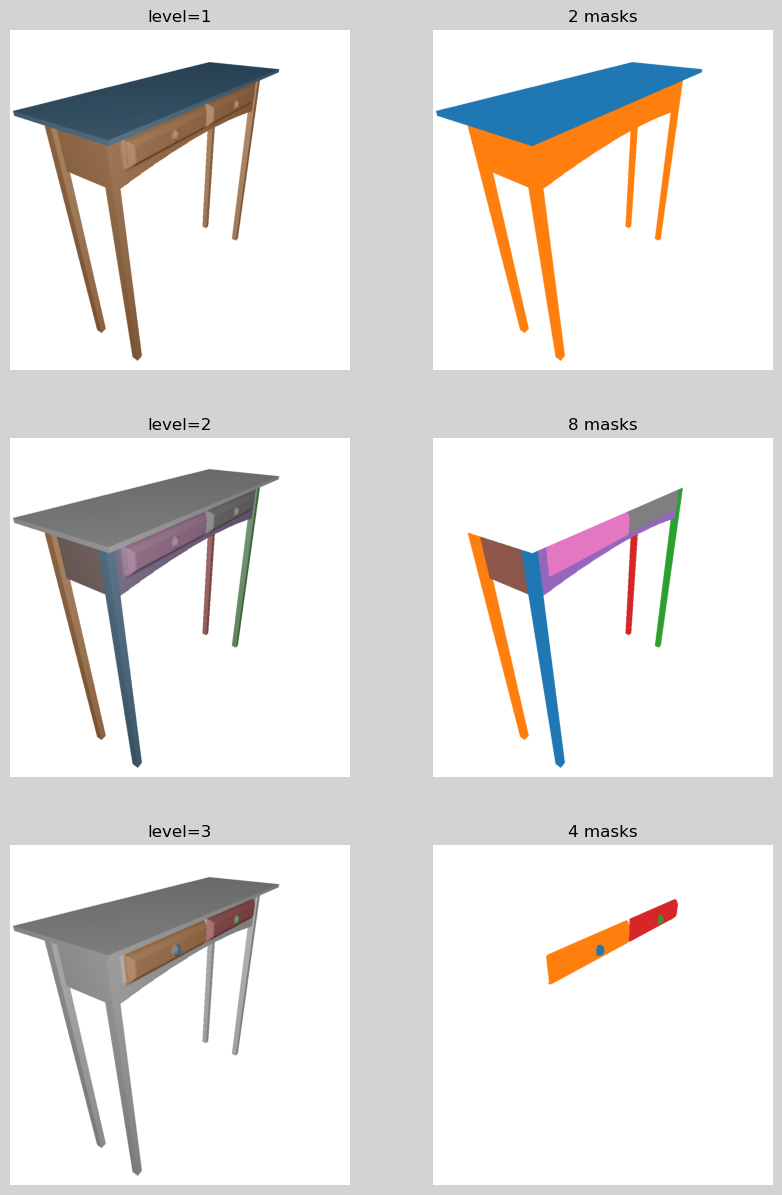

In [8]:
show_index = 8
num_level = show_all_levels(images[show_index, :, :, :3], gt, tri_ids[show_index], facecolor='lightgray')
plt.show()

# Fast Segment 2D

In [40]:
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
print(model.__class__.__name__)
predictor = TreePredictor(model, stability_score_thresh=0.92)

SemanticSAM


In [ ]:
show_index = 8
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
show_all_levels(image, tree_data, facecolor='lightgray', width=6)

In [ ]:
def build_view_graph(area, tri_ids: Tensor, threshold=0.5, num_nearest=5):
    N_view = tri_ids.shape[0]
    view_masks = torch.zeros((N_view, area.shape[0] + 1), device=device)
    for i in range(N_view):
        v_faces = tri_ids[i].unique()
        if v_faces[0] == 0:
            v_faces = v_faces[1:]
        view_masks[i, v_faces] = 1
    # print(area.shape)
    A = F.linear(view_masks[:, 1:], view_masks[:, 1:] * area)
    mask_area = torch.mv(view_masks[:, 1:], area)
    # A = A / (area[:, None] + area[None, :] - A).clamp_min(1e-7)
    A = A / mask_area[:, None]
    indices = torch.topk(A, num_nearest + 1, dim=0)[1]
    # print(utils.show_shape(indices))
    A = A.ge(threshold)
    A[torch.arange(N_view), indices] = 1
    return A


# Gv = build_view_graph(gt.area, tri_ids)
# print(utils.show_shape(Gv))

In [ ]:
features_2d = []
for i in tqdm(range(num_views)):
    continue
    predictor.set_image((images[i, :, :, :3] * 255).to(torch.uint8).cpu().numpy())
    features_2d.append(utils.tensor_to(predictor.features, device=torch.device('cpu')))
print(utils.show_shape(features_2d))

In [ ]:
results_2d = [Tree2D(device=device) for _ in range(num_views)]
for i in tqdm(range(num_views)):
    continue
    points = results_2d[i].sample_grid(32)
    predictor.features = utils.tensor_to(features_2d[i], device=device)
    data = predictor.process_points(points)
    results_2d[i].cat(data)
    results_2d[i].update_tree()
    results_2d[i].remove_not_in_tree()
    results_2d[i].compress()
for j in range(10):
    for i in tqdm(range(num_views)):
        points = []

# Slow Segment 2D

In [41]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(num_views)):
    if 0 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        data = torch.load(cache_dir.joinpath(f"view_{index:04d}.data"), map_location='cpu')
        assert torch.all(data['tri_id'].eq(tri_ids[index].cpu()))
    else:
        tree_data = predictor.tree_generate(
            (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
            max_steps=100,
            in_threshold=0.8,
            union_threshold=0.1,
            min_mask_region_area=100,
            points_per_update=256,
            device=device,
            in_thre_area=50,
            verbose=1,
        )
        data = {
            'tree_data': tree_data.save(filename=None),
            'tri_id': tri_ids[index].clone(),
            'image': images[index].clone(),
            'Tw2v': Tw2vs[index].clone(),
        }
        torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)
    # break

  0%|                                                                                                                                                | 0/100 [00:00<?, ?it/s]

[Tree] reset
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 7 to 7
[Tree2D] complete init segmentation


  0%|                                                                                                                                                | 0/100 [00:16<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 │   │   data = torch.load(cache_dir.joinpath(f"view_{index:04d}.data"), map_location='cp    │
│    7 │   │   assert torch.all(data['tri_id'].eq(tri_ids[index].cpu()))                           │
│    8 │   else:                                                                                   │
│ ❱  9 │   │   tree_data = predictor.tree_generate(                                                │
│   10 │   │   │   (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),                 │
│   11 │   │   │   max_steps=100,                                                                  │
│   12 │   │   │   in_threshold=0.8,                                                               │
│                                                                                                  │
│ /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/torch/utils/_contextlib.py:115 in      │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/predictor.py:208 in tree_generate      │
│                                                                                                  │
│   205 │   │   │   if timer is not None:                                                          │
│   206 │   │   │   │   timer.log('decode', len(points))                                           │
│   207 │   │   │   num_masks += len(data['masks'])                                                │
│ ❱ 208 │   │   │   num_ignored += tree2d.insert_batch(data)                                       │
│   209 │   │   │   del data                                                                       │
│   210 │   │   │   # tree_data.update_tree()                                                      │
│   211 │   │   │   tree2d.remove_not_in_tree()                                                    │
│                                                                                                  │
│ /home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/tree_2d_segmentation.py:433 in         │
│ insert_batch                                                                                     │
│                                                                                                  │
│   430 │   │   │   scores = torch.ones(masks.shape[0], device=masks.device)                       │
│   431 │   │   num_ignored = 0                                                                    │
│   432 │   │   for i in range(len(masks)):                                                        │
│ ❱ 433 │   │   │   if self.insert(masks[i], scores[i]) < 0:                                       │
│   434 │   │   │   │   num_ignored += 1                     

0: Tree Root
├── 1
│   ├── 3
│   │   └── 10
│   ├── 4
│   └── 5
└── 2
    ├── 6
    ├── 7
    │   ├── 11
    │   │   ├── 18
    │   │   │   ├── 20
    │   │   │   └── 21
    │   │   └── 19
    │   │       ├── 22
    │   │       ├── 23
    │   │       └── 24
    │   ├── 12
    │   └── 13
    ├── 8
    │   ├── 14
    │   └── 15
    └── 9
        ├── 16
        └── 17

BoolTensor[24, 1024, 1024], None, F16Tensor[24]


0: Tree Root
└── 1
    ├── 2
    │   ├── 6
    │   └── 7
    ├── 3
    │   ├── 8
    │   └── 9
    ├── 4
    │   ├── 10
    │   ├── 11
    │   └── 12
    │       ├── 13
    │       │   ├── 15
    │       │   ├── 16
    │       │   └── 17
    │       └── 14
    │           ├── 18
    │           └── 19
    └── 5

True


6

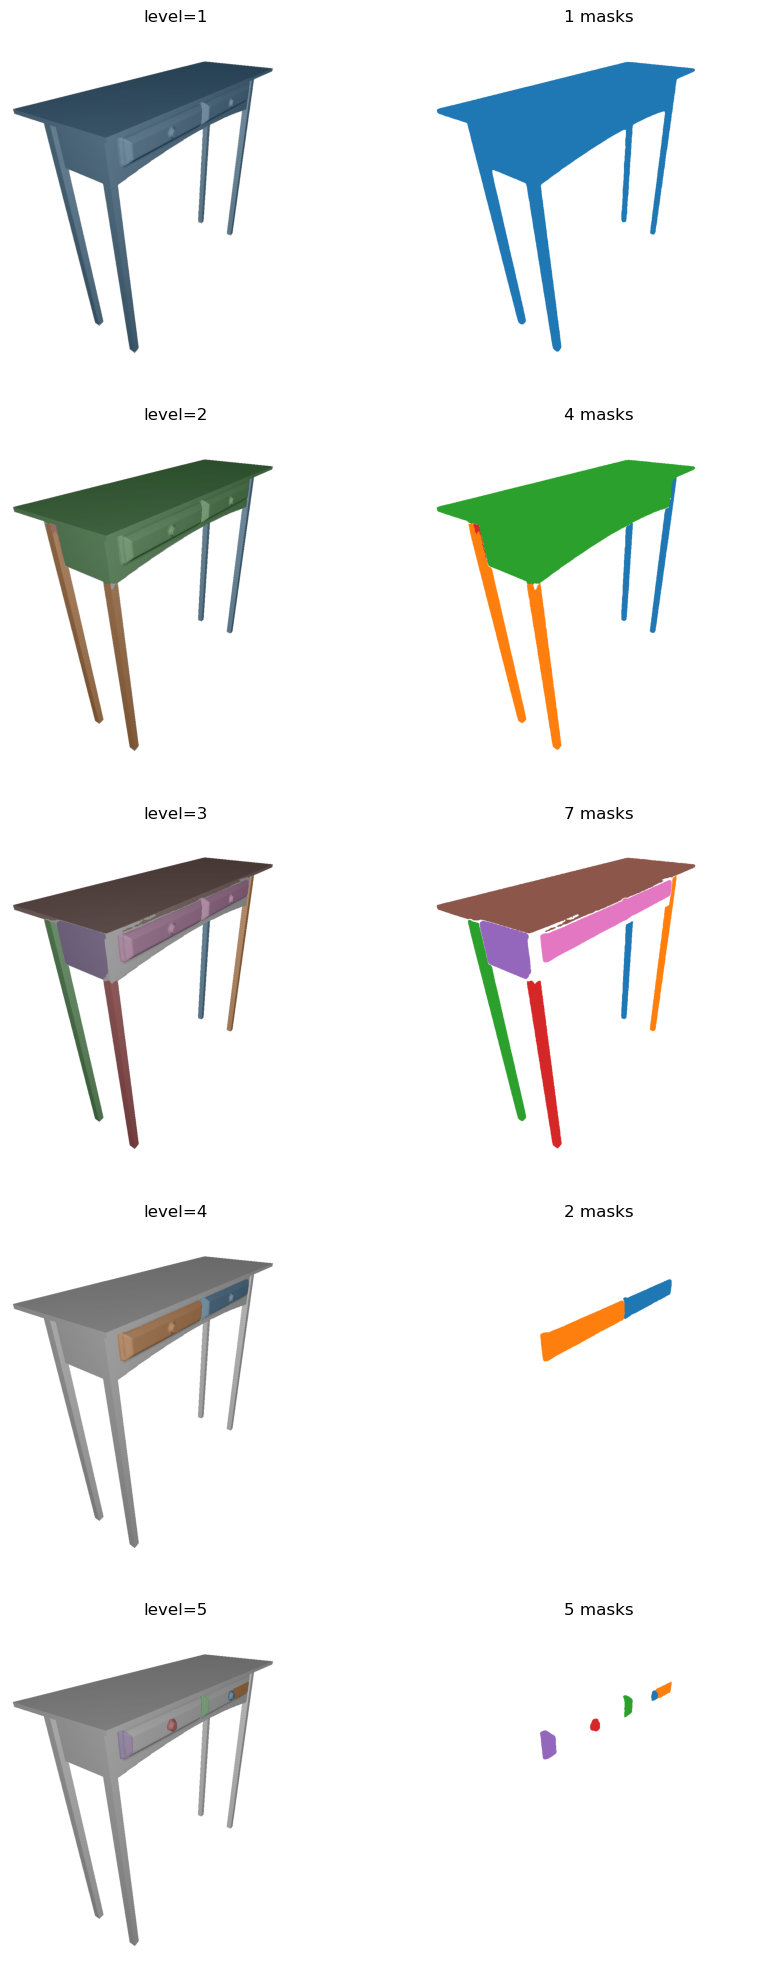

In [13]:
show_index = 8
data = torch.load(cache_dir.joinpath(f"view_{show_index:04d}.data"))
tree_data = Tree2D(device=device)
tree_data.load(None, **data['tree_data'])
tree_data.print_tree()
tree_data.remove_background(tri_ids[show_index].eq(0).to(device))
tree_data.print_tree()
print(isinstance(tree_data, Tree2D))
show_all_levels(images[show_index, :, :, :3], tree_data)

# 3D Tree Segmentation

In [25]:
from tree_segmentation import Tree3Dv2

timer = utils.TimeWatcher()
timer.start()
tree3d = Tree3Dv2(mesh, device=device)
timer.log('new')
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=False)
timer.log('load 2d')
# Gv = tree3d.build_view_graph()
# timer.log('Gv')
# Gm = tree3d.build_graph(Gv)
# timer.log('Gm')
A = tree3d.build_all_graph()
timer.log('A')
X, autoencoder = tree3d.compress_masks(epochs=3000)
timer.log('X')
print(autoencoder)
print(timer)

[Tree3D] GPU: (2.8384013175964355, 11.904052734375)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[7], 'first': IntTensor[7], 'next': IntTensor[7], 'last': IntTensor[7], 'cnt': 6, 'num_samples': IntTensor[7], 'masks': IntTensor[3, 1024, 1024], 'scores': F16Tensor[6], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (2.835538387298584, 11.904052734375)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 30569], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1244 masks, max_num: 22
[Tree3D] GPU: (4.34188175201416, 11.904052734375)
[Tree3D] X epoch[   0], loss: recon= 0.712, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.193, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.062, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.048, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.044, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.042, lr=9.328e-04
[Tree3D] X epoch

In [30]:
A = tree3d.build_all_graph()
print(A[tree3d.M:, tree3d.M:].aminmax())
print(A[:tree3d.M, :tree3d.M].aminmax())
print(A[:tree3d.M, tree3d.M:].aminmax())
print(A[tree3d.M:, :tree3d.M].aminmax())

torch.return_types.aminmax(
min=tensor(0., device='cuda:0'),
max=tensor(1., device='cuda:0'))
torch.return_types.aminmax(
min=tensor(0., device='cuda:0'),
max=tensor(1., device='cuda:0'))
torch.return_types.aminmax(
min=tensor(0., device='cuda:0'),
max=tensor(1.0000, device='cuda:0'))
torch.return_types.aminmax(
min=tensor(0., device='cuda:0'),
max=tensor(0., device='cuda:0'))


In [38]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').to(device)
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=A * (A >= 0.5), X=X, topP=False)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 44, num_layers=2)
[Tree3D] GPU: (3.4821786880493164, 11.904052734375)
[Tree3D] GPU: (2.875478744506836, 11.904052734375)
[Tree3D] Epoch 100: loss=1.566911, match= 0.737, vm= 0.792, mv= 0.107, tree= 0.059
[Tree3D] Epoch 200: loss=1.493872, match= 0.589, vm= 0.690, mv= 0.143, tree= 0.046
[Tree3D] Epoch 300: loss=1.220328, match= 0.543, vm= 0.647, mv= 0.145, tree= 0.045
[Tree3D] Epoch 400: loss=0.973482, match= 0.458, vm= 0.579, mv= 0.153, tree= 0.045
[Tree3D] Epoch 500: loss=1.038958, match= 0.407, vm= 0.532, mv= 0.159, tree= 0.045
[Tree3D] Epoch 600: loss=1.172036, match= 0.411, vm= 0.532, mv= 0.149, tree= 0.043
[Tree3D] Epoch 700: loss=1.021358, match= 0.392, vm= 0.517, mv= 0.148, tree= 0.041
[Tree3D] Epoch 800: loss=1.218902, match= 0.360, vm= 0.482, mv= 0.147, tree= 0.039
[Tree3D] Epoch 900: loss=0.939333, match= 0.350, vm= 0.470, mv= 0.149, tree= 0.038
[Tree3D] Epoch 1000: loss=0.880703, match= 0.356, vm= 0.471, mv= 0.141, tree= 0.036
[Tree3D] Epoch 1100: loss=0.574809, mat

In [ ]:
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X, topP=True)

tensor([0.9591, 0.9314, 0.9180, 0.8380, 0.8369, 0.8367, 0.8347, 0.8326, 0.8277, 0.8215, 0.7932, 0.7901, 0.7882, 0.7853,
        0.7682, 0.7572, 0.7527, 0.7460, 0.7458, 0.7433, 0.7368, 0.7352, 0.7351, 0.7038, 0.6873, 0.6794, 0.6752, 0.6686,
        0.6397, 0.6294, 0.6150, 0.6054, 0.6046, 0.5855, 0.4030, 0.3285, 0.2978, 0.2928, 0.2706, 0.2321, 0.1800, 0.1591,
        0.1407, 0.1332], device='cuda:0')


0: Tree Root
├── 18
├── 10
└── 6
    ├── 23
    ├── 19
    │   ├── 3
    │   └── 15
    ├── 17
    ├── 9
    ├── 1
    │   └── 4
    └── 5
        ├── 24
        ├── 22
        └── 20
            ├── 32
            │   ├── 14
            │   ├── 13
            │   ├── 12
            │   └── 8
            │       └── 2
            ├── 25
            │   └── 26
            └── 7
                └── 16

BoolTensor[44, 30569]
SQ 0.5492458939552307
RQ 0.7804878048780488
PQ 0.4286797221113996
TS 0.9827794432640076
TQ 0.4212975800037384
mSQ 0.6943920850753784
mRQ 0.5101881623268127
mPQ 0.37192022800445557
mTS 0.9887650609016418
mTQ 0.3671632409095764
mIoU 0.487383633852005


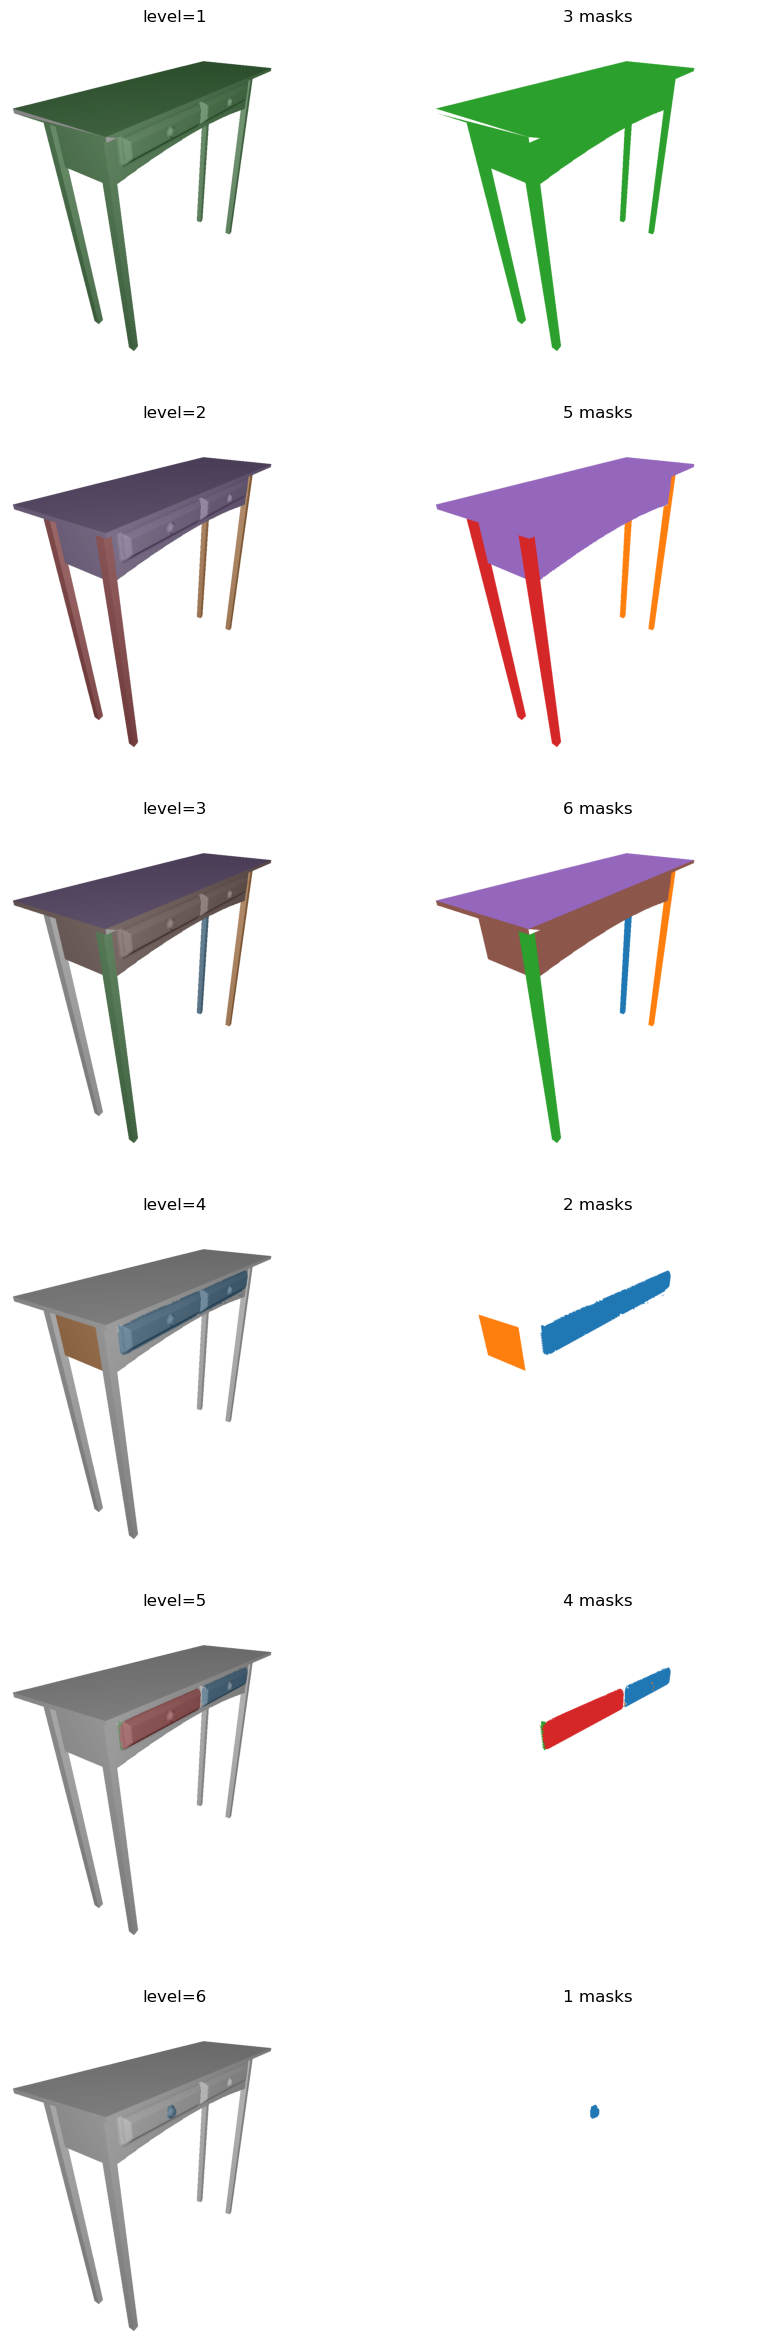

In [39]:
print(tree3d.scores)
# tree3d.set_score_threshold(0.5)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()
print(utils.show_shape(tree3d.masks))
# tree3d.save(cache_dir.joinpath('my.tree3dv2'))

from tree_segmentation.metric import TreeSegmentMetric

metric = TreeSegmentMetric()
metric.update(tree3d.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# tree3d.print_tree()
# pack 0.3105152130126953 0.2907191812992096
# unpack: 0.3666433095932007 0.2955842912197113
#                                    PQ      TQ    mTQ    mIoU
# [recon + match + vm + mv + tree]: 0.3958 0.3895 0.3755 0.4176
# [recon + match + vm      + tree]: 0.3239 0.3197 0.3293 0.4097
# [      + match + vm + mv + tree]: 0.3300 0.3264 0.2752 0.4291
# [      + match + vm + mv + tree]: 0.4288 0.4213 0.3672 0.4874
# [recon + match           + tree]:
# [recon + match + vm            ]:


# 3D Tree Segmentation use GT 2D results

In [9]:
from tree_segmentation.tree_3d_segmentation import Tree3Dv2

tree3d_gt = Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt, tri_ids)
# Gv_ = tree3d_gt.build_view_graph()
# Gm_ = tree3d_gt.build_graph(Gv_)
A_ = tree3d_gt.build_all_graph()
X_, autoencoder = tree3d_gt.compress_masks(epochs=3000)
print(autoencoder)
# print(utils.show_shape(Gv_, Gm_, X_))
print(utils.show_shape(A_, X_))

[Tree] reset
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 30569], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1082 masks, max_num: 16
[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.710, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.201, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.065, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.048, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.038, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.036, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.033, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.030, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.028, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.026, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.023, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.022, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.020, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.018, lr

In [42]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=A_*(A_>=0.5), X=X_)
# tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))

GCN(256, 32, num_layers=2)
[Tree3D] GPU: (5.717360973358154, 11.904052734375)
[Tree3D] GPU: (3.8028783798217773, 11.904052734375)
[Tree3D] Epoch 100: loss=1.475781, match= 0.606, vm= 0.713, mv= 0.142, tree= 0.060
[Tree3D] Epoch 200: loss=1.016513, match= 0.435, vm= 0.521, mv= 0.161, tree= 0.050
[Tree3D] Epoch 300: loss=0.993382, match= 0.297, vm= 0.419, mv= 0.176, tree= 0.043
[Tree3D] Epoch 400: loss=0.814516, match= 0.260, vm= 0.366, mv= 0.166, tree= 0.031
[Tree3D] Epoch 500: loss=0.821852, match= 0.209, vm= 0.321, mv= 0.163, tree= 0.027
[Tree3D] Epoch 600: loss=0.704262, match= 0.180, vm= 0.298, mv= 0.162, tree= 0.023
[Tree3D] Epoch 700: loss=0.573133, match= 0.154, vm= 0.280, mv= 0.171, tree= 0.020
[Tree3D] Epoch 800: loss=0.596538, match= 0.119, vm= 0.253, mv= 0.169, tree= 0.018
[Tree3D] Epoch 900: loss=0.597796, match= 0.090, vm= 0.232, mv= 0.161, tree= 0.015
[Tree3D] Epoch 1000: loss=0.475447, match= 0.068, vm= 0.220, mv= 0.164, tree= 0.013
[Tree3D] Epoch 1100: loss=0.146930, mat

In [11]:
tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))
print(tree3d_gt.scores, tree3d_gt)

[Tree3D] Save results to /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28/gt_seg.tree3dv2
tensor([0.9498, 0.9495, 0.9206, 0.9116, 0.9115, 0.8914, 0.8639, 0.8394, 0.8084, 0.8023, 0.8000, 0.7786, 0.7701, 0.7249,
        0.7138, 0.7116, 0.7045, 0.6650, 0.6428, 0.6232, 0.6077, 0.5359, 0.5238, 0.5085, 0.4229, 0.4085, 0.3465, 0.2526,
        0.1608, 0.1367, 0.0298, 0.0152], device='cuda:0') <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7f3600742880>


0: Tree Root
├── 4
│   ├── 19
│   ├── 17
│   ├── 16
│   ├── 14
│   ├── 11
│   ├── 10
│   ├── 9
│   ├── 8
│   ├── 6
│   ├── 5
│   ├── 2
│   └── 3
└── 1

SQ 0.8004392896379743
RQ 0.9333333333333333
PQ 0.747076670328776
TS 0.9993449449539185
TQ 0.746587336063385
mSQ 0.9391657114028931
mRQ 0.5439491271972656
mPQ 0.5069633722305298
mTS 0.9996256828308105
mTQ 0.5067296028137207
mIoU 0.8519638776779175


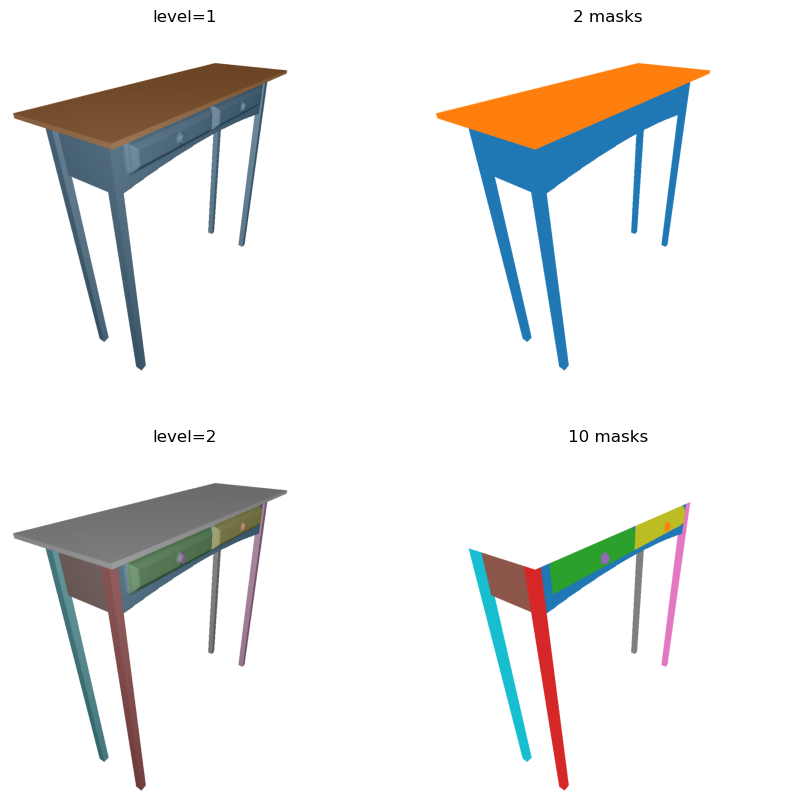

In [43]:
# tree3d_gt.in_threshold = 0.9
# tree3d_gt.set_score_threshold(0.7)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
# tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# without tree loss: 0.5807471451935945 0.4203405976295471
# with tree loss:0.733435549054827 0.5524243116378784
#                                    PQ      TQ    mTQ    mIoU
# [recon + match + vm + mv + tree]: 0.8307 0.8304 0.5245 0.9265
# [recon + match + vm      + tree]: 0.8336 0.8335 0.5321 0.9298
# [recon + match           + tree]: 0.4149 0.4109 0.2976 0.7683
# [      + match + vm      + tree]: 0.8331 0.8330 0.5299 0.9293
# [recon + match + vm            ]: 0.7220 0.7213 0.4840 0.8515

# Other Attempt

In [ ]:
@torch.enable_grad()
def run(Adj: Tensor, Attr: Tensor, t: Tree3Dv2, epochs=5000):
    gnn = pyg.nn.GCN(
        in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=128, norm='BatchNorm').cuda()

    opt = torch.optim.Adam(gnn.parameters(), lr=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, 1e-6)

    edges = torch.nonzero(Adj).T
    edge_weights = Adj[edges[0], edges[1]]
    print(utils.show_shape(edges, edge_weights))

    for epoch in range(epochs):
        opt.zero_grad()
        view_index = torch.randint(0, t.N_view, (1,)).item()
        view_mask = t.view_infos[view_index][0]
        print('view_mask', utils.show_shape(view_mask))
        features = gnn(Attr, edges, edge_weight=edge_weights)
        print(utils.show_shape(features))
        start_index, end_index = t.view_range[view_index]
        for u in range(start_index, end_index):
            linked = edges[1, edges[0] == u]
            scores = 1 - F.relu(-torch.mv(features[linked], features[u]))  # shape: [Nu]
            linked = F.pad(linked, (0, 1), value=u)
            scores = F.pad(scores, (0, 1), value=1)  # TODO: 权重参数化
            mask_u = scores @ t.face_masks[linked]  # shape: [Nu, F]
            print(utils.show_shape(scores, linked, t.view_masks[t.view_indices[linked]], mask_u))
            mask_u = mask_u / (scores @ t.view_masks[t.view_indices[linked]]).clamp_min(1e-7)
            mask_u = mask_u[view_mask]
            print((mask_u - t.face_masks[u, view_mask]).abs().sum())
            diff = F.mse_loss(mask_u, t.face_masks[u, view_mask])  # to FocalLoss
            print(utils.show_shape(mask_u), diff)
            # print(u, utils.show_shape(linked, scores), linked, scores)
        opt.step()
        lr_scheduler.step()
        break


run(Gm_ * (Gm_ >= 0.5), X, tree3d_gt)

# Simple Merge

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

In [ ]:
def get_score(tree: Tree3Dv2, indices: Tensor, Mask: Tensor = None):
    if not isinstance(indices, Tensor):
        indices = torch.tensor(indices, device=tree.device)
    view_mask_ = tree.view_masks[tree.view_indices[indices], 1:]
    masks_ = tree.face_masks[indices, 1:]
    # print(utils.show_shape(indices, view_mask_, masks_))
    if Mask is None:
        Mask = (masks_.sum(dim=0) / view_mask_.sum(dim=0).clamp_min(1e-7)) >= 0.5
    masks_M = Mask[None, :] * view_mask_
    area_M = torch.mv(masks_M, tree.area)
    area_m = torch.mv(masks_, tree.area)
    inter = (masks_M * masks_ * tree.area).sum(dim=1)
    iou = inter / (area_m + area_M - inter).clamp_min(1e-7)
    # print(iou)
    return iou.mean()


# assert 0 <= my.face_masks.min() and my.face_masks.max() <= 1., my.face_masks.aminmax()
def run_simple_merge(tree: Tree3Dv2, threshold=0.9, num_min=2):
    visited = torch.zeros(tree.M, device=tree.device, dtype=torch.bool)
    masks = []

    for i in range(tree.M):
        if visited[i]:
            continue
        visited[i] = True
        mask = tree.face_masks[i].clone()
        cnt = tree.view_masks[tree.view_indices[i]].clone()
        que = [i]

        while True:
            update = False
            for k in range(tree.M):
                if not visited[k] and (tree.A[que, k] >= 0.5).any():
                    mask_k, cnt_k = tree.face_masks[k], tree.view_masks[tree.view_indices[k]]
                    mask_ = (mask + mask_k) / (cnt + cnt_k).clamp_min(1e-7) >= 0.5
                    score = get_score(tree, que + [k], mask_[1:])
                    # print(f'k={k}, score={score}')
                    if score > threshold:
                        que.append(k)
                        visited[k] = True
                        mask += mask_k
                        cnt += cnt_k
                        update = True
                        break
            if not update:
                break
        if len(que) >= num_min:
            mask = mask / cnt.clamp_min(1e-7) >= 0.5
            score = get_score(tree, que, mask[1:])
            masks.append((que, mask, score))
            print(f'Number: {len(que)}, score={score}')
    tree.resize(len(masks) + 1)
    scores, indices = torch.sort(torch.stack([x[2] for x in masks]), descending=True)
    tree.masks = torch.stack([x[1] for x in masks])[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return masks


def run_simple_merge_2(tree: Tree3Dv2, threshold=0.9, num_min=2):
    is_obj = torch.ones(tree.M, device=tree.device, dtype=torch.bool)
    A = tree.A.clone()  # type: Tensor
    masks = tree.face_masks.clone()  # type: Tensor
    cnts = tree.view_masks[tree.view_indices]
    merge = {i: [i] for i in range(tree.M)}
    print(utils.show_shape(masks, cnts, A))
    # for uv in torch.nonzero(A):
    #     u, v = uv.tolist()
    #     A[u, v] = get_score(tree, [u, v])

    while Tree:
        indices = torch.argmax(A).item()
        u, v = indices // A.shape[1], indices % A.shape[1]
        # print(f'u={u}, v={v}, iou={A[u, v]}')
        if A[u, v] < threshold:
            break
        # merge u, v
        merge[u] = merge[u] + merge.pop(v)
        is_obj[v] = False
        masks[u] += masks[v]
        cnts[u] += cnts[v]
        # update A
        indices = (A[u, :] > 0) | (A[v, :] > 0)
        indices[u] = False
        indices[v] = False
        A[v, :] = 0
        A[:, v] = 0
        for w in torch.nonzero(indices):
            w = w.item()
            mask = ((masks[u] + masks[w]) / (cnts[u] + cnts[w]).clamp_min(1e-7)) >= 0.5
            A[u, w] = A[w, u] = get_score(tree, merge[u] + merge[w], mask[1:])
        # view_masks = tree.view_masks[tree.view_indices[indices], 1:]
        # masks_e = masks[indices, 1:] * view_masks
        # mask = (masks[u]  / cnts[u].clamp_min(1e-7)) >= 0.5
        # mask = mask[None, 1:] * view_masks
        # # print('masks:', utils.show_shape(masks, masks_e))
        # area_u = torch.mv(mask, tree.area)
        # area_e = torch.mv(masks_e, tree.area)
        # # print('area:', utils.show_shape(area_e, area_u))
        # inter = torch.mv(masks_e * mask, tree.area)
        # iou = inter / (area_u + area_e - inter).clamp_min(1e-7)
        # # print('iou:', utils.show_shape(iou, inter))
        # # print(iou)
        # A[u, indices] = iou
        # A[indices, u] = iou
        # # break
        # return

    masks = (masks[is_obj] / cnts[is_obj].clamp_min(1e-7)) >= 0.5
    scores = []
    for i in torch.nonzero(is_obj):
        indices = merge[i.item()]
        if len(indices) < num_min:
            continue
        scores.append(get_score(tree, indices))
    scores, indices = torch.sort(torch.tensor(scores, device=masks.device), descending=True)
    print('score, masks', utils.show_shape(scores, masks))
    print('num:', [len(v) for k, v in merge.items() if len(v) >= num_min])
    tree.cnt = 0
    tree.resize(len(masks) + 1)
    tree.masks = masks[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return scores

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

run_simple_merge(my)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.7612818479537964 0.44708824157714844

In [ ]:
run_simple_merge_2(my, threshold=0.9)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# use score (0.9): 0.8394677562098349 0.5187289118766785
# use score (0.8): 0.8401441881733556 0.5180656313896179
# use IoU: 0.5285388484145656 0.2708543539047241

In [ ]:
my2 = Tree3Dv2(mesh, device=device)
my2.load_2d_results(cache_dir)
my2.build_graph(my2.build_view_graph())

run_simple_merge(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.15785423590212452 0.08242347091436386

In [ ]:
run_simple_merge_2(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.17959821419637712 0.11583688855171204

# V-M Graph

In [9]:
tree3d_gt = ts.Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt, tri_ids)

[Tree] reset
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 30569], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1082 masks, max_num: 16


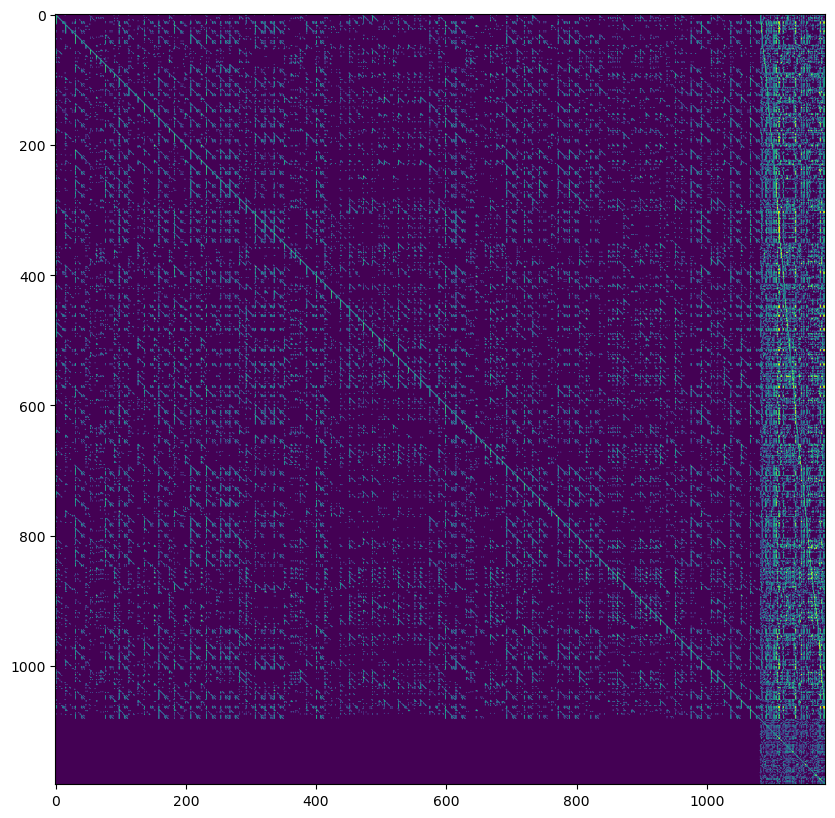

In [35]:
V = tree3d_gt.V
M = tree3d_gt.M
N = M + V
A = torch.zeros((N, N), device=device)
# view-view
area = torch.mv(tree3d_gt.masks_view[:, 1:].float(), tree3d_gt.area)
A[M:, M:] = F.linear(tree3d_gt.masks_view[:, 1:].float(), tree3d_gt.masks_view[:, 1:] * tree3d_gt.area) / area[:, None]
# view-mask
areas_m = torch.mv(tree3d_gt.masks_2d[:, 1:], tree3d_gt.area)
A[:M, M:] = F.linear(tree3d_gt.masks_2d[:, 1:], tree3d_gt.masks_view[:, 1:].float() * tree3d_gt.area) / areas_m[:, None]
# mask-mask
A[:M, :M] = F.linear(tree3d_gt.masks_2d[:, 1:], tree3d_gt.masks_2d[:, 1:].float() * tree3d_gt.area) / areas_m[:, None]

plt.figure(figsize=(10, 10))
plt.imshow((A * (A > 0.5)).cpu().numpy())
plt.show()

In [27]:
X, _ = tree3d_gt.compress_masks(epochs=3000, include_views=True)

[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.192, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.061, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.045, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.039, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.034, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.031, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.030, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.028, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.026, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.023, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.022, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.020, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.019, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.017, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.016, lr=5.000e-04
[Tree3D] X epoch[1600], loss: recon= 0.016, lr=4.478e-04
[Tree3D] X epoch[1700], loss: r

In [33]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=A * (A > 0.5), X=X)
# tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))

GCN(256, 32, num_layers=2)
[Tree3D] GPU: (1.766345500946045, 11.904052734375)
[Tree3D] GPU: (1.5089354515075684, 11.904052734375)
[Tree3D] Epoch 100: loss=1.516580, match= 0.718, mm= 0.770, tree= 0.069
[Tree3D] Epoch 200: loss=1.361184, match= 0.584, mm= 0.642, tree= 0.063
[Tree3D] Epoch 300: loss=0.401151, match= 0.576, mm= 0.615, tree= 0.060
[Tree3D] Epoch 400: loss=1.311932, match= 0.482, mm= 0.553, tree= 0.060
[Tree3D] Epoch 500: loss=0.982518, match= 0.478, mm= 0.542, tree= 0.063
[Tree3D] Epoch 600: loss=0.923642, match= 0.481, mm= 0.518, tree= 0.064
[Tree3D] Epoch 700: loss=0.324845, match= 0.433, mm= 0.470, tree= 0.063
[Tree3D] Epoch 800: loss=1.059690, match= 0.427, mm= 0.454, tree= 0.061
[Tree3D] Epoch 900: loss=1.180794, match= 0.439, mm= 0.444, tree= 0.059
[Tree3D] Epoch 1000: loss=0.816962, match= 0.408, mm= 0.428, tree= 0.058
[Tree3D] Epoch 1100: loss=1.145740, match= 0.429, mm= 0.413, tree= 0.057
[Tree3D] Epoch 1200: loss=0.774964, match= 0.422, mm= 0.411, tree= 0.058
[Tr

0: Tree Root
├── 12
├── 10
└── 8
    ├── 20
    ├── 16
    ├── 2
    ├── 4
    └── 7
        └── 1

SQ 0.44549698299831814
RQ 0.72
PQ 0.3207578277587891
TS 0.9874051213264465
TQ 0.3167179226875305
mSQ 0.633765459060669
mRQ 0.21609601378440857
mPQ 0.17469418048858643
mTS 0.9913851618766785
mTQ 0.1726098358631134
mIoU 0.570273220539093


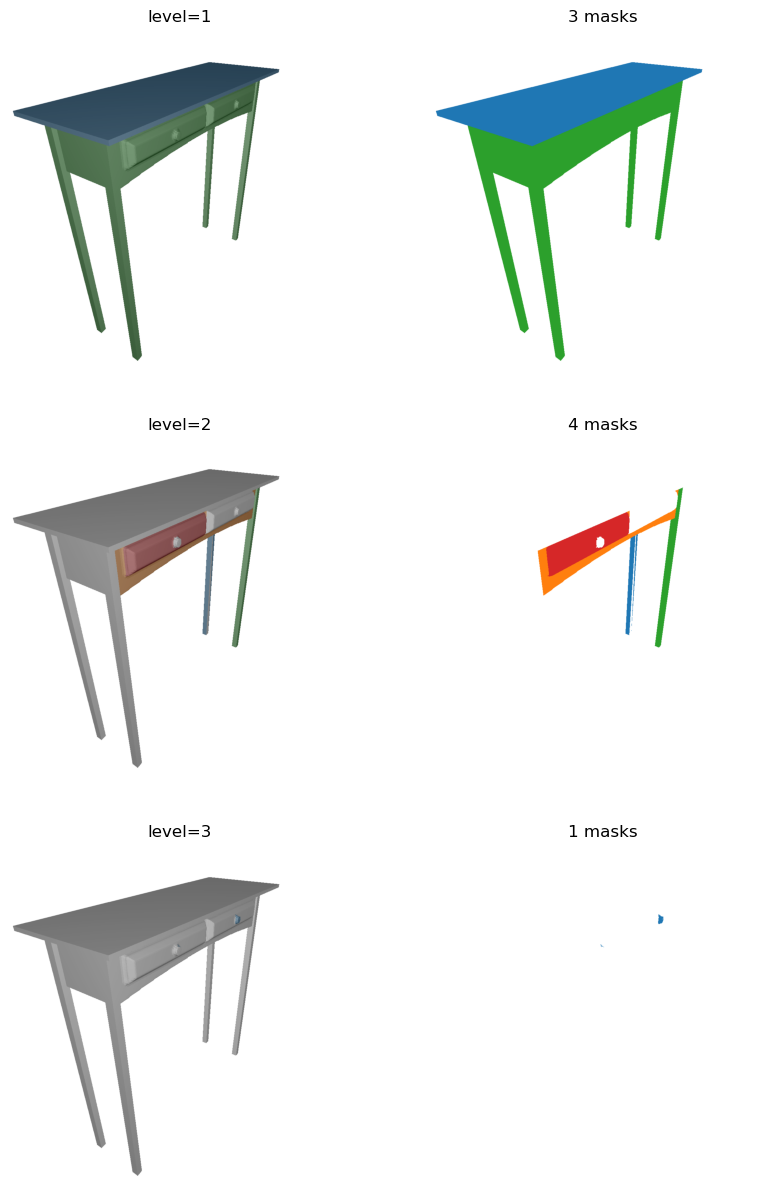

In [34]:
# tree3d_gt.in_threshold = 0.9
# tree3d_gt.set_score_threshold(0.7)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
# tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# without tree loss: 0.5807471451935945 0.4203405976295471
# with tree loss:0.733435549054827 0.5524243116378784